# Notes

- One step eulerian advection
- KLD of pretrained models
- New arch

In [33]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as sf
from IPython import display
import math as mt
import matplotlib.animation as animation
import xarray as xr
import seaborn as sns
sns.reset_defaults()
sns.set_context("talk", font_scale=0.8)
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### advection with Eulerian numerical scheme 

In [63]:
import myfuncts 

gt, ml, ml12, eul=myfuncts.load_eul()

#Eulerian one step used for advection
#alpha = dt/(2*dx)
#gamma = ( dt) / (dx*dy)
#n[j,i] = -alpha*(u[j,i]*(n[j,i+1]-n[j,i-1])+v[j,i]*(n[j+1,i]-n[j-1,i])) + gamma*(n[j,i+1]+n[j,i-1] + n[j-1,i] + n[j+1,i]-4*n[j,i]) +n[j,i]


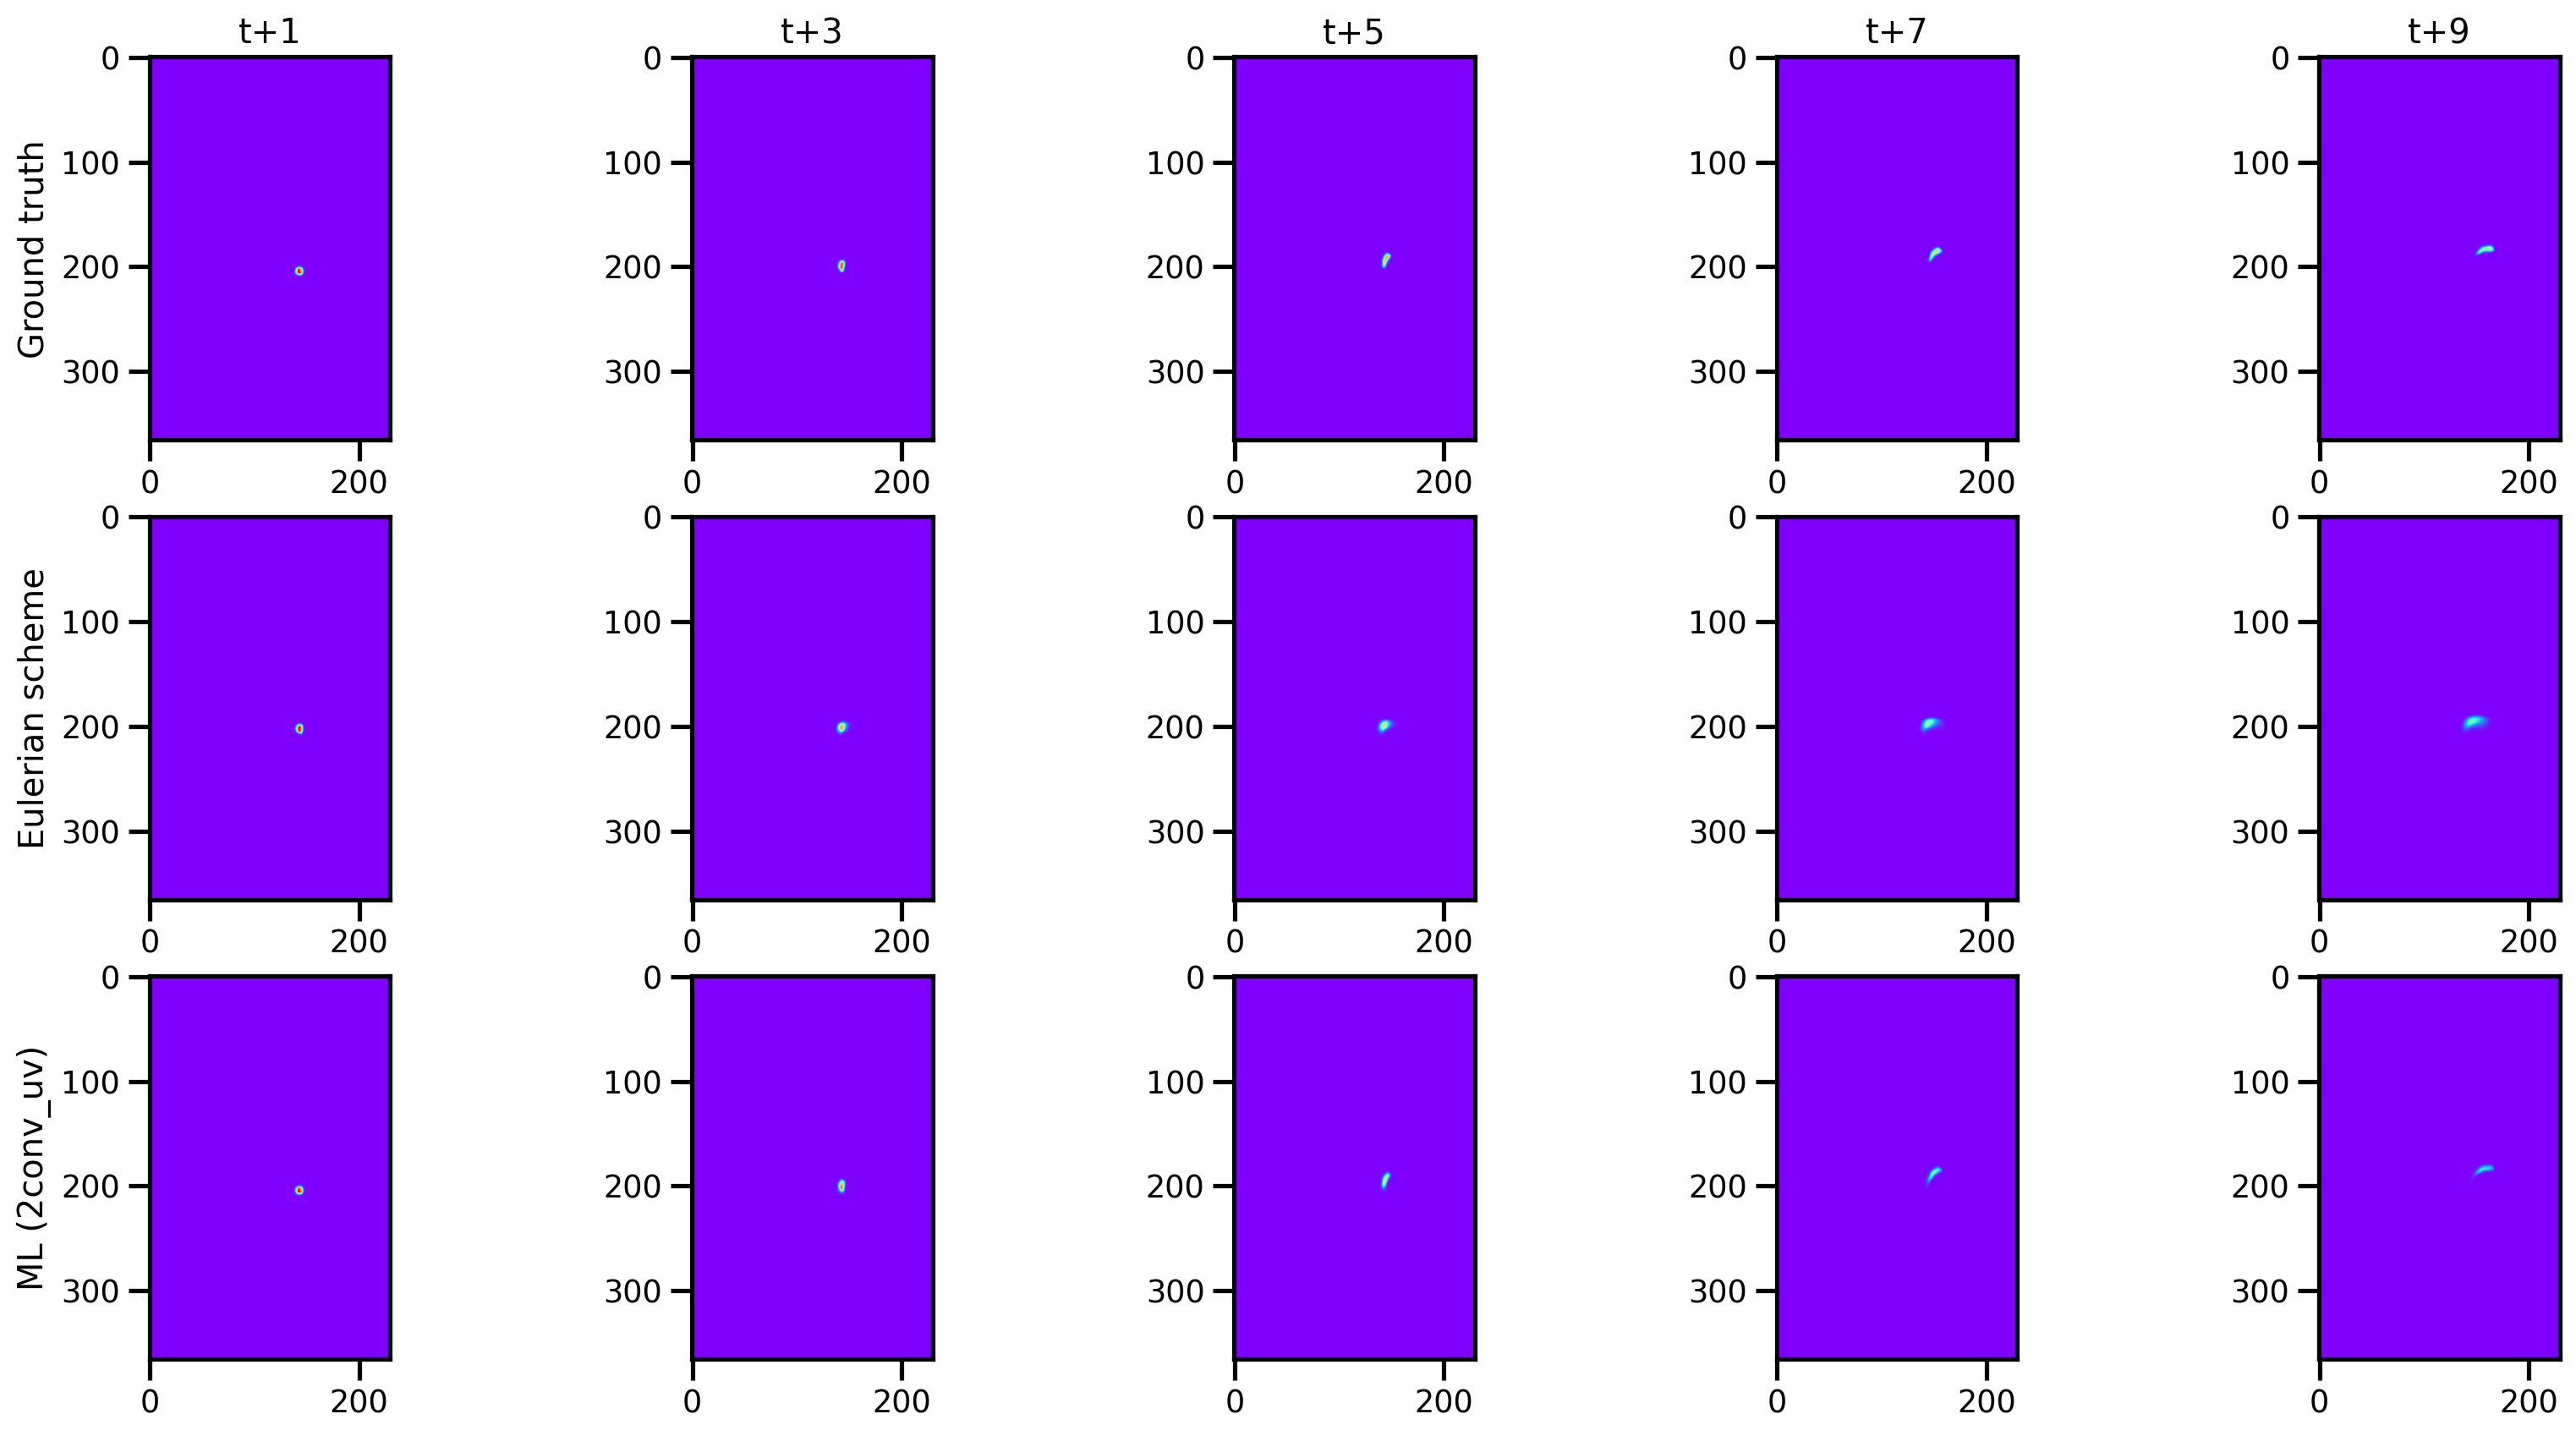

In [10]:
import matplotlib.cm as cm                                                                                                                                                                          
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20,10))
axs.shape

for j in range(5):
    i=j*2
    axs[0,j].imshow(gt[i],cmap=cm.rainbow, vmin=0, vmax=1)
    axs[1,j].imshow(eul[i],cmap=cm.rainbow, vmin=0, vmax=1)
    axs[2,j].imshow(ml[i],cmap=cm.rainbow, vmin=0, vmax=1)
    axs[0,j].title.set_text('t+' + str(i+1))

    
axs[0,0].set_ylabel('Ground truth')
axs[1,0].set_ylabel('Eulerian scheme')
axs[2,0].set_ylabel('ML (2conv_uv)')
plt.show()

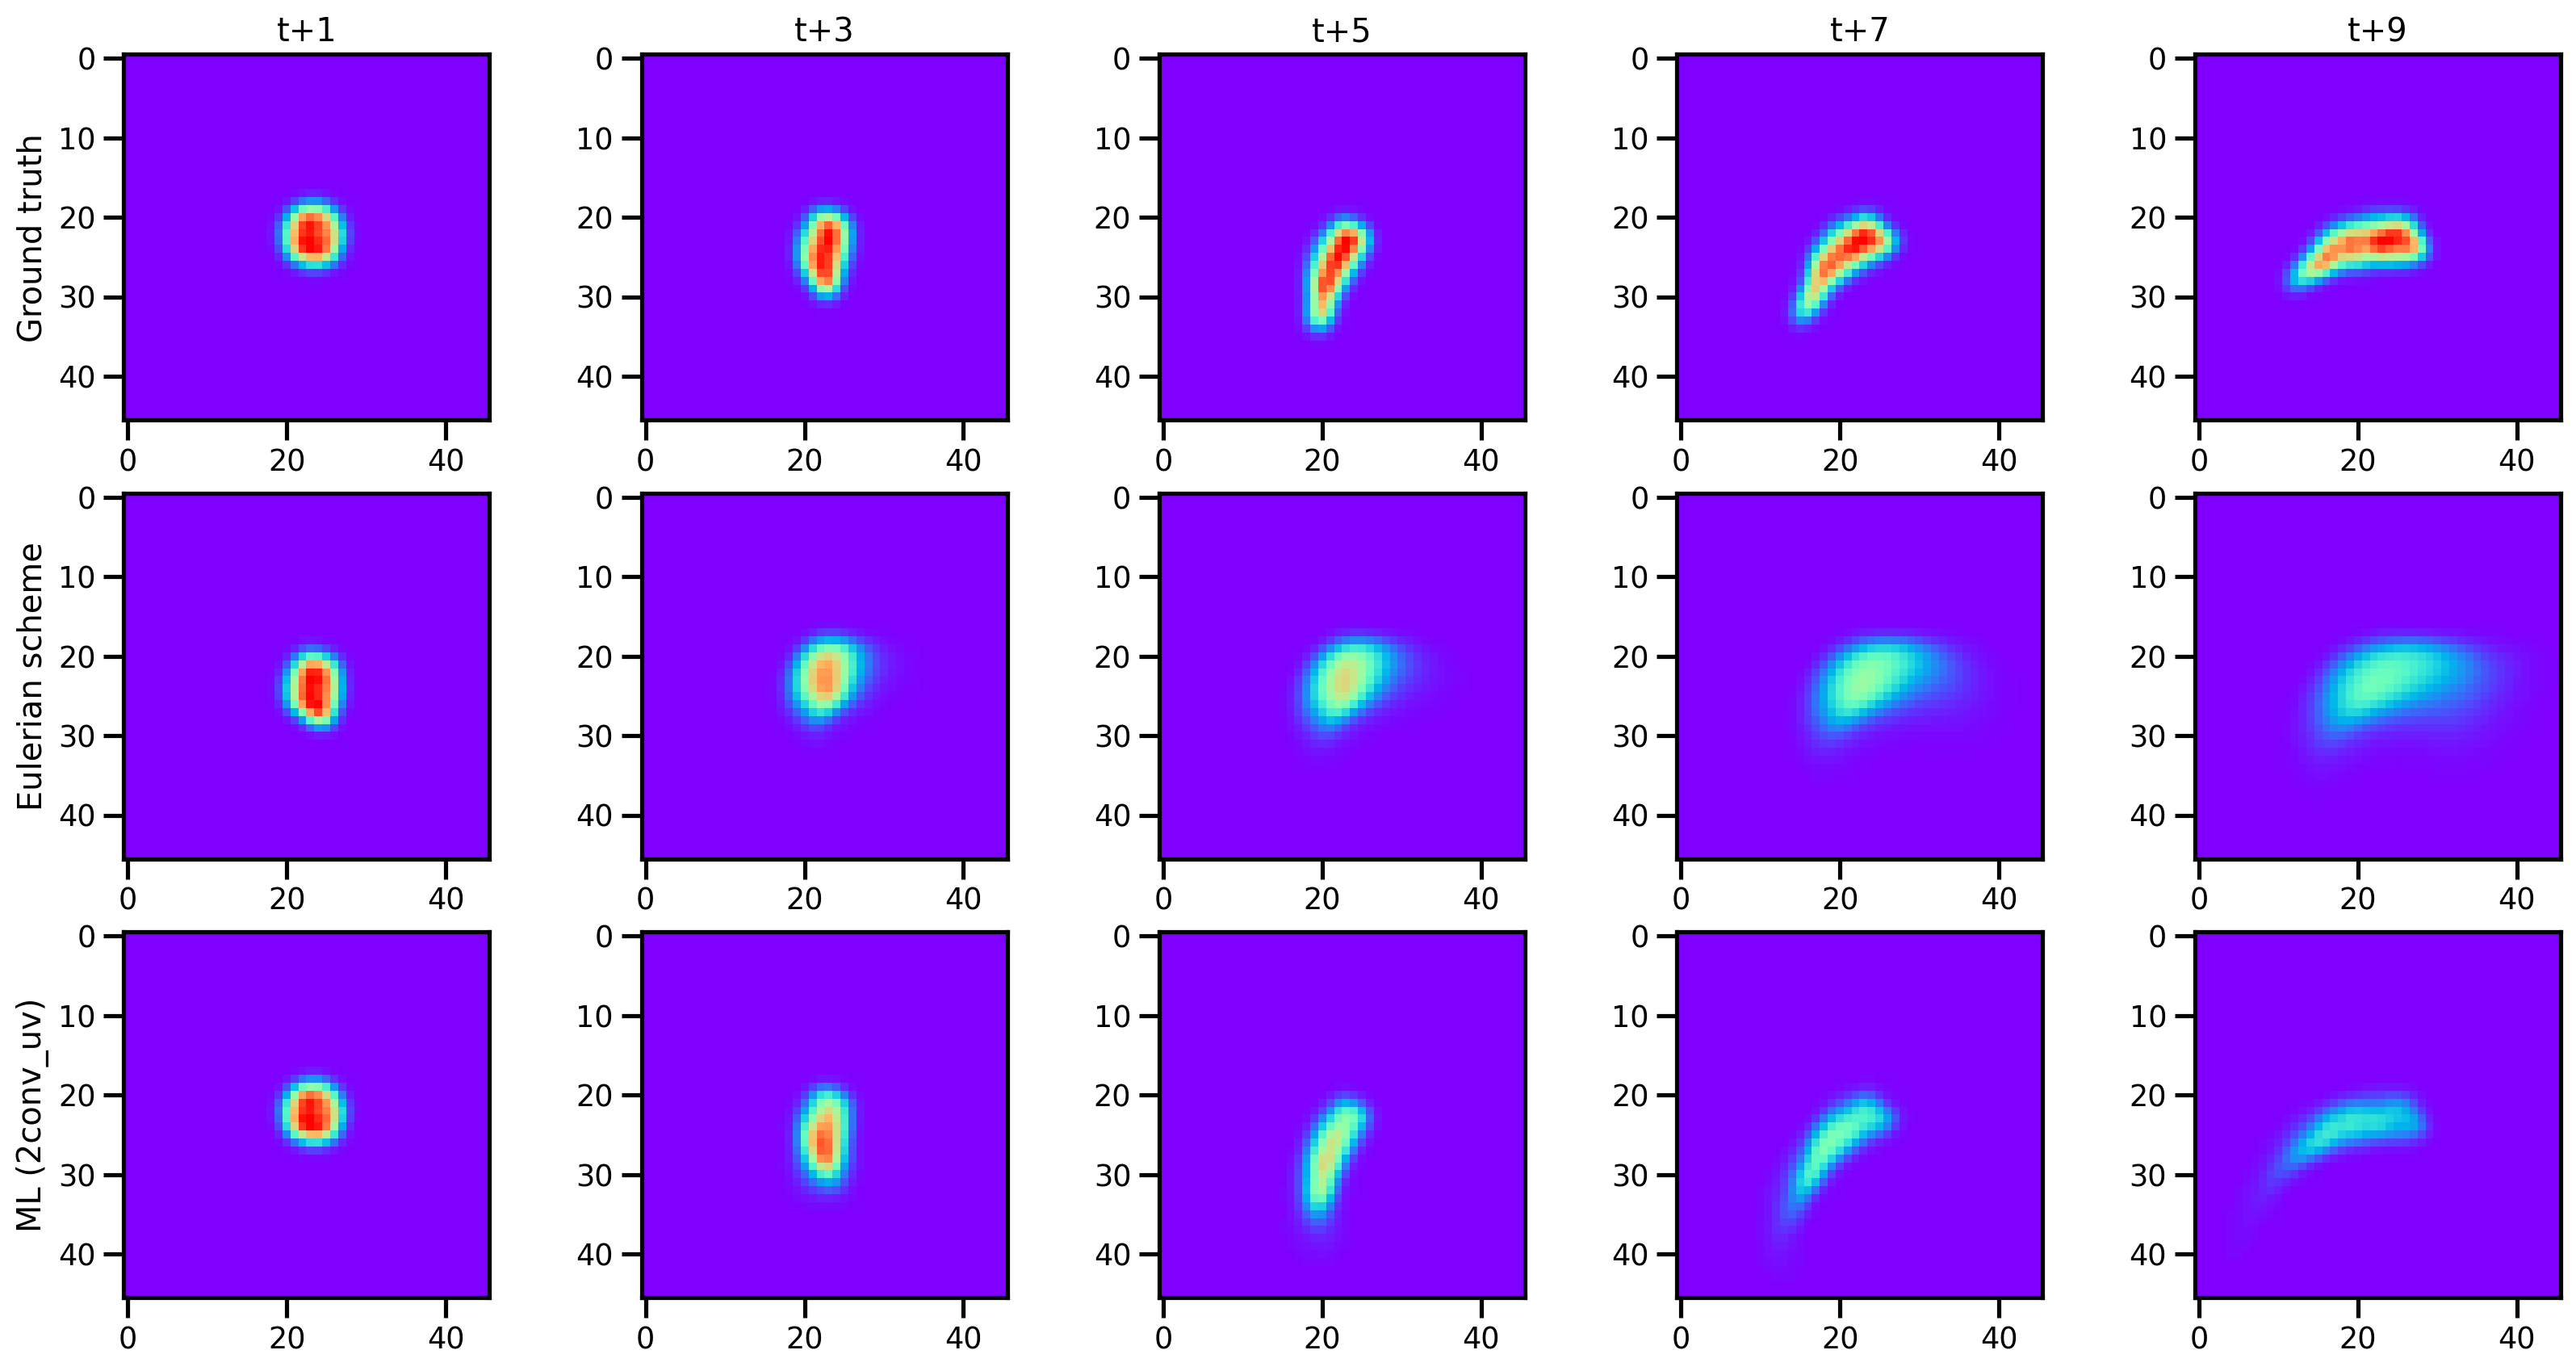

In [11]:
import matplotlib.cm as cm                                                                                                                                                                          
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20,10))
axs.shape


k=23
for j in range(5):
    i=2*j
    ind = np.unravel_index(np.argmax(eul[i], axis=None), eul[i].shape)
    ind1 = np.unravel_index(np.argmax(gt[i], axis=None), gt[i].shape)
    #print(ind)
    axs[0,j].imshow(gt[i,ind1[0]-k:ind1[0]+k,ind1[1]-k:ind1[1]+k],cmap=cm.rainbow)
    axs[1,j].imshow(eul[i,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],cmap=cm.rainbow, vmin=0, vmax=1)
    axs[2,j].imshow(ml[i,ind1[0]-k:ind1[0]+k,ind1[1]-k:ind1[1]+k],cmap=cm.rainbow, vmin=0, vmax=1)
    axs[0,j].title.set_text('t+' + str(i+1))

axs[0,0].set_ylabel('Ground truth')
axs[1,0].set_ylabel('Eulerian scheme')
axs[2,0].set_ylabel('ML (2conv_uv)')
plt.show()

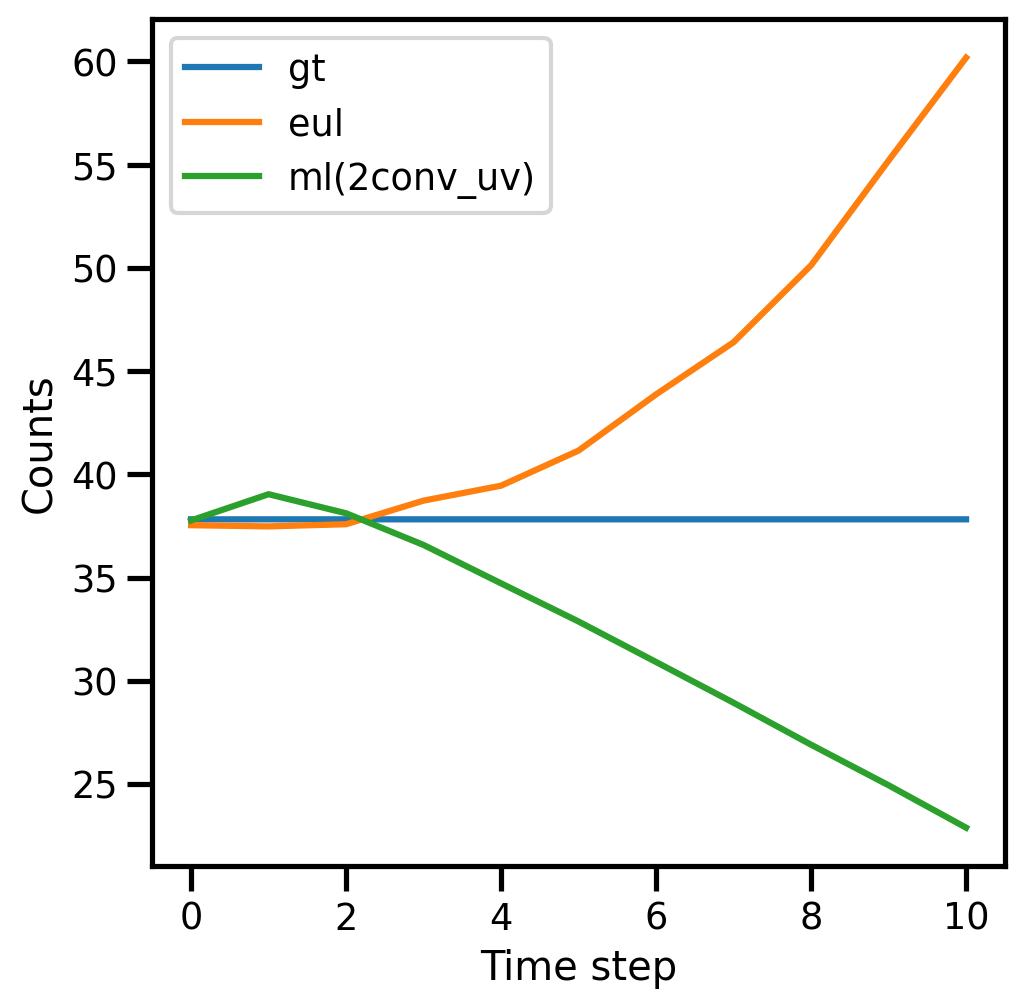

In [65]:

gt_=np.zeros(11)
eul_=np.zeros(11)
ml_=np.zeros(11)

for i in range(11):
    gt_[i]=gt[i].sum()
    eul_[i]=eul[i].sum()
    ml_[i]=ml[i].sum()

plt.rcParams["figure.figsize"] = [5.50, 5.50]
plt.plot(gt_, label='gt')
plt.plot(eul_, label='eul')
plt.plot(ml_, label='ml(2conv_uv)')
    #print(sim.name)
plt.ylabel('Counts')
plt.xlabel('Time step')
plt.legend()

plt.show()

## Plot KDL of pretrained models

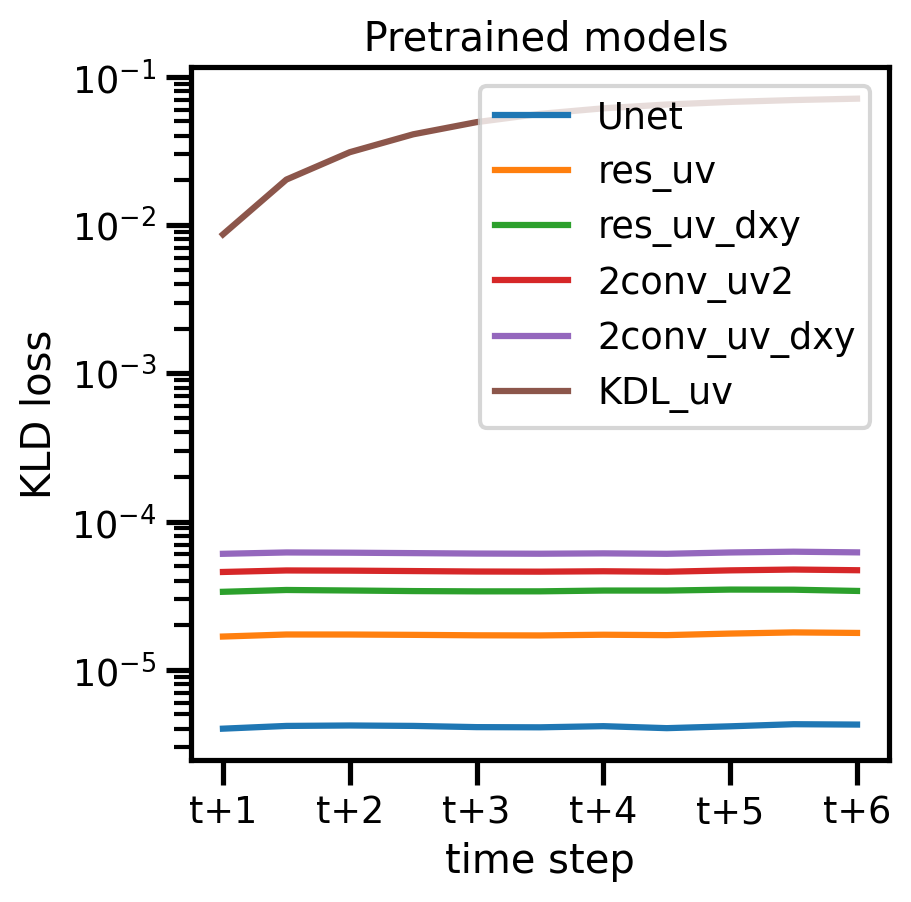

In [71]:
simulations=['Unet','res_uv', 'res_uv_dxy', '2conv_uv2','2conv_uv_dxy', 'KDL_uv']

datapath='/home/anas/MEOM_Workspace/data/models/snapshot/UNet/'


ml.shape



import torch.nn.functional as F
import torch

plt.rcParams["figure.figsize"] = [4.50, 4.50]
norm = 0.43405532837#sims[0].tloss.values[0]
f, (ax1) = plt.subplots(1, 1, sharey=True)



for j in simulations:
    losses=np.zeros(120)
    ml = xr.open_dataset("/home/anas/MEOM_Workspace//data/models/snapshot/UNet/"+ j +"/maps.nc").density_map_ml.values[:,-1,:,:]
    gt = xr.open_dataset("/home/anas/MEOM_Workspace//data/models/snapshot/UNet/"+ j +"/maps.nc").density_map_gt.values[:,-1,:,:]


    for i in range(120):
        a=torch.from_numpy(ml[i])
        b=torch.from_numpy(gt[i])
        a_lsm=F.log_softmax(a)
        b_sm = F.softmax(b)
        out = F.kl_div(a_lsm,b_sm, None, None, 'sum')/(366*230)
        losses[i]=out
        #print(out.detach().numpy())

    aa=np.reshape(losses, (10,12)).mean(axis=0)
    ax1.plot(aa[1:],label=j)
    #print(aa)



        
ax1.title.set_text(' Pretrained models')
ax1.set_ylabel('KLD loss')
ax1.set_xlabel('time step')
ax1.legend()
ax1.set_yscale('log')
ax1.set_xticklabels(['0','t+1', 't+2', 't+3', 't+4', 't+5', 't+6'], rotation='0')

plt.show()

# learn the whole sequence: 12 2-conv architecture

![Drag Racing](figs/scheme.png)


In [12]:
import myfuncts 
def rmse(y1, y2):                                                                                                                                                                                   
    return np.sqrt(((y1-y2)**2)).mean()  

ds=myfuncts.load_5d()

pred0=rmse(ds[-1,1,:,:],0*ds[-1,1,:,:])

print(pred0)

0.00046393462


Unet : 3.43431114719e-05
res_uv : 0.0001221591000936
12_2conv_uv : 6.76595436605e-05
res_uv_dxy : 0.0001188649484119
2conv_uv : 0.0001243431114719


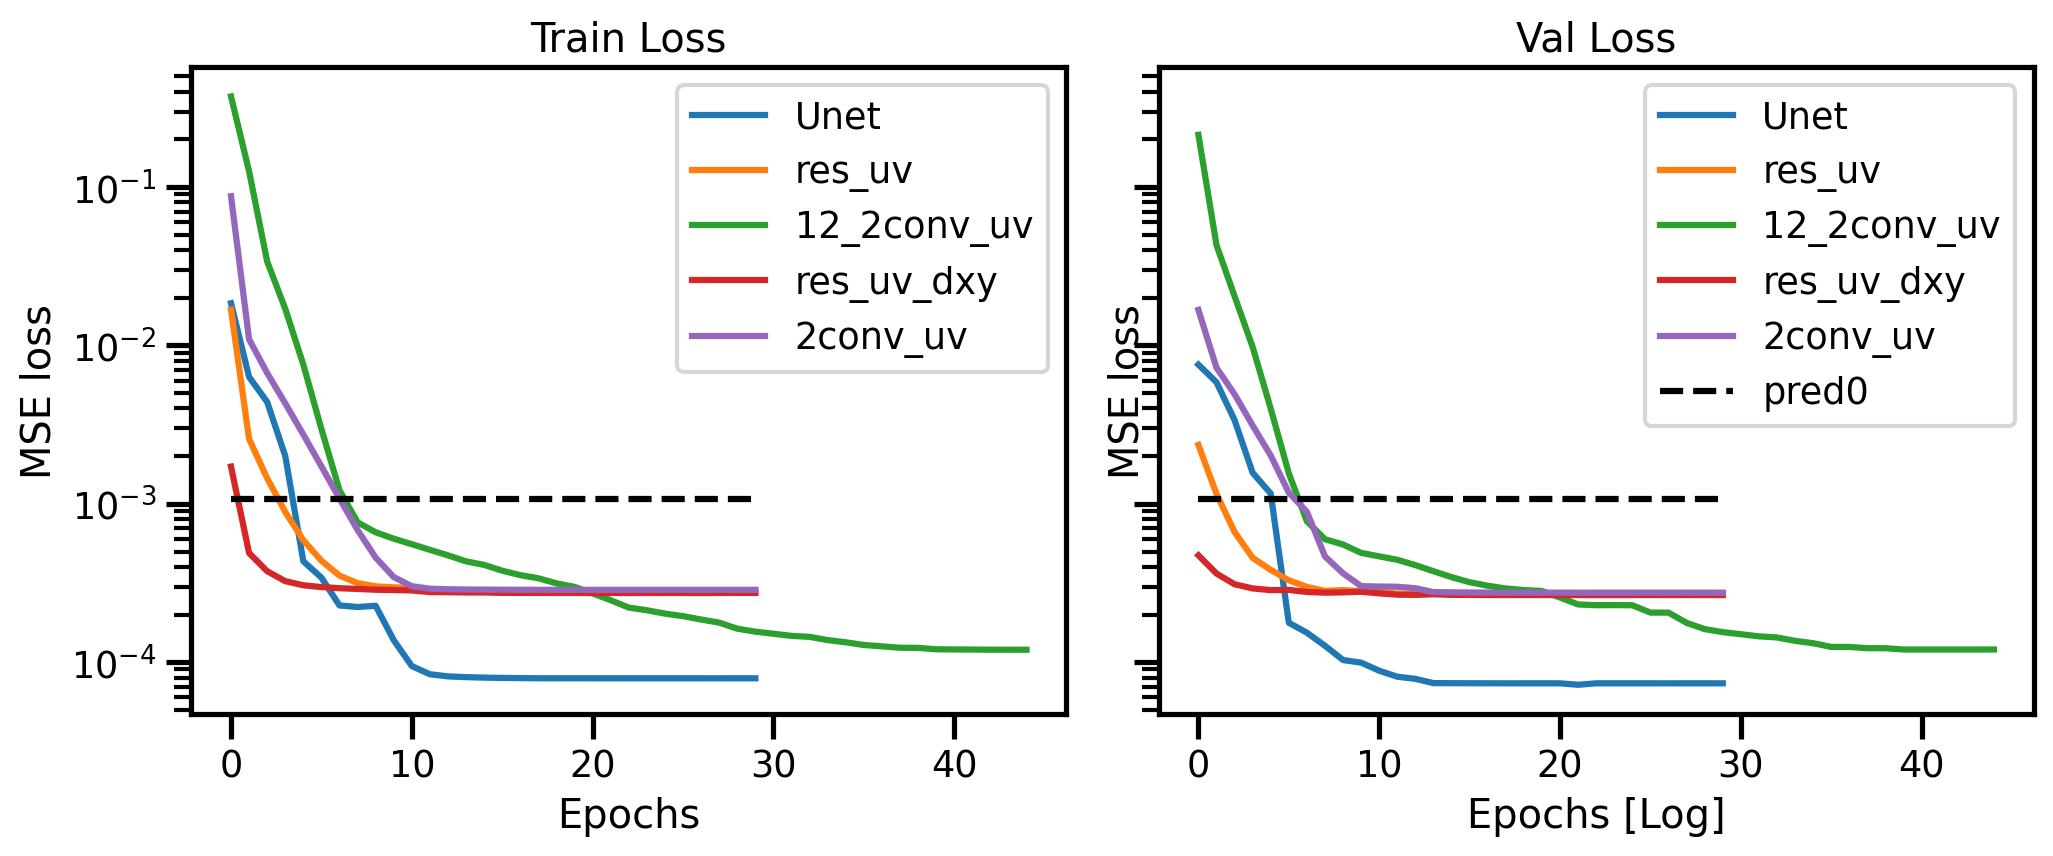

In [13]:
import myfuncts 

sims=myfuncts.load_sims4()


plt.rcParams["figure.figsize"] = [10.50, 4.50]
norm = 0.43405532837#sims[0].tloss.values[0]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
for sim in sims:
        ax1.plot((sim.tloss/norm),label=sim.name)
        ax2.plot((sim.vloss/norm),label=sim.name)
        print(sim.name +' :', sim.tloss[29])
        
ax1.title.set_text('Train Loss')
ax1.set_ylabel('MSE loss')
ax1.set_xlabel('Epochs')
ax1.legend()
ax1.set_yscale('log')
#ax1.set_xscale('log')
ax2.plot(((pred0+0*sim.tloss)/norm),'k--',label='pred0')
ax1.plot(((pred0+0*sim.tloss)/norm),'k--',label='pred0')

ax2.title.set_text('Val Loss')
ax2.set_ylabel('MSE loss')
ax2.set_xlabel('Epochs [Log]')
ax2.legend()
#ax2.set_yscale('log')
#ax2.set_xscale('log')
#ax2.set_xlim([20, 45])
plt.tight_layout()
plt.show()

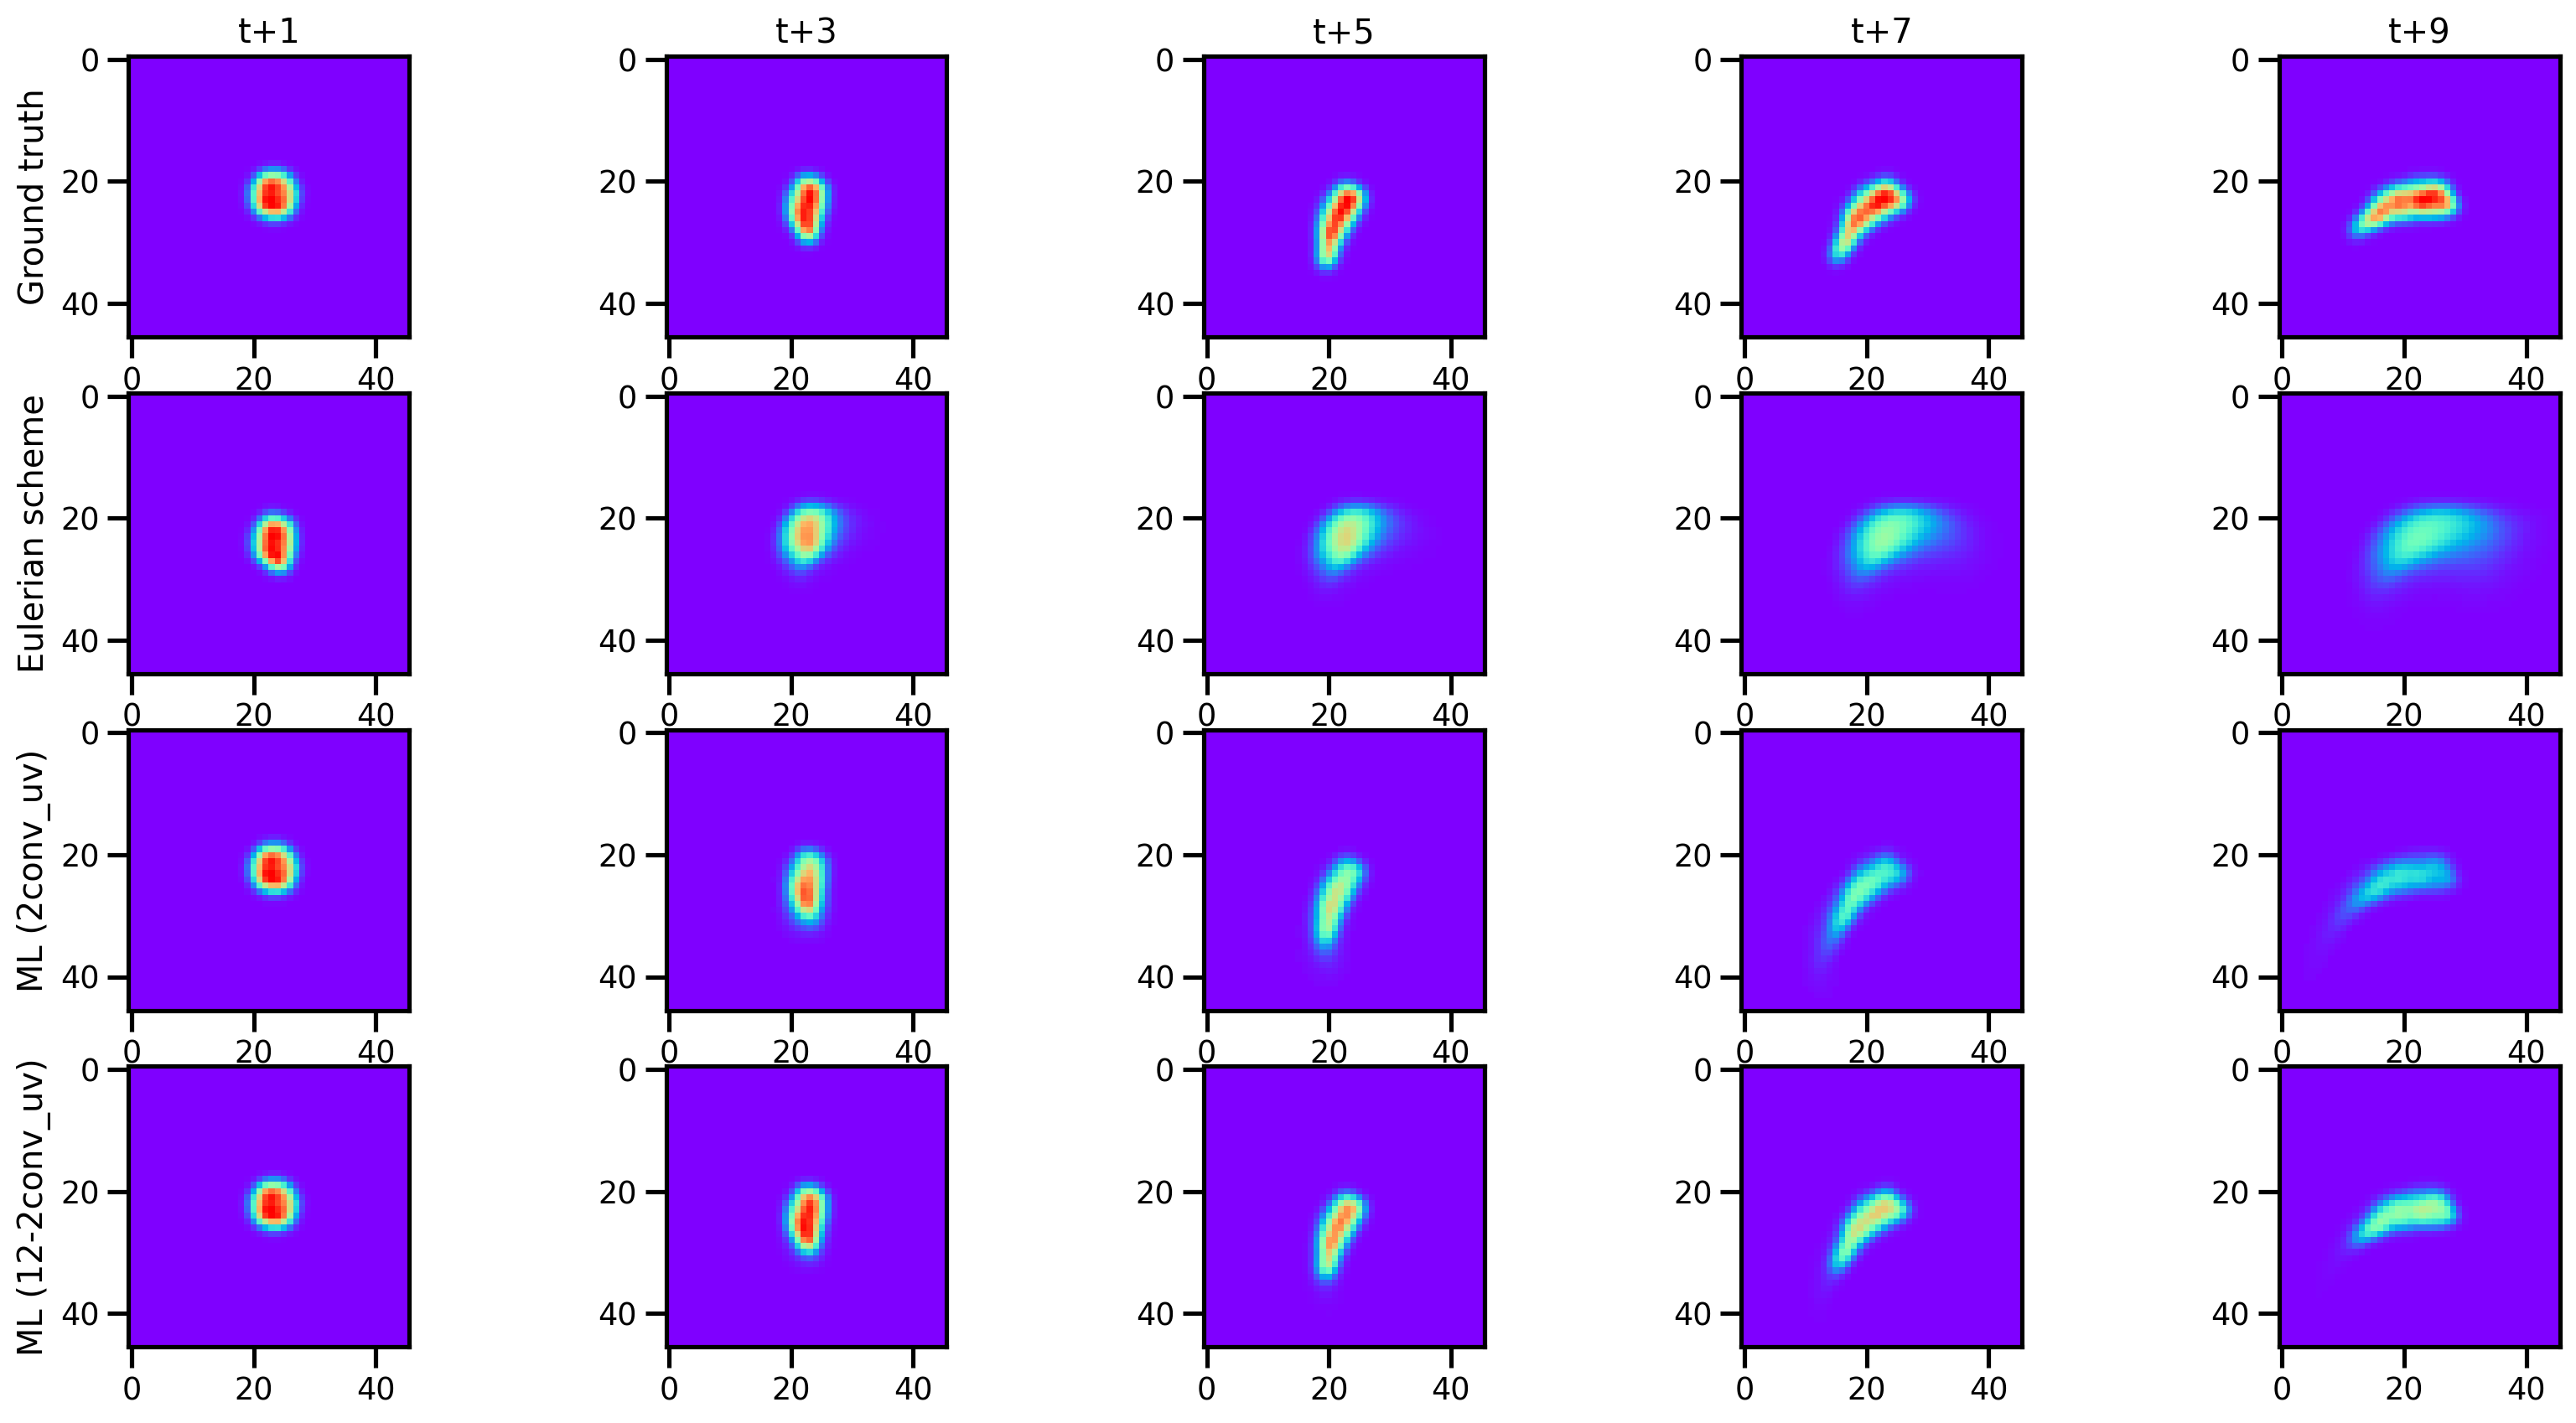

In [16]:
import matplotlib.cm as cm                                                                                                                                                                          
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(20,10))
axs.shape


k=23
for j in range(5):
    i=2*j
    ind = np.unravel_index(np.argmax(eul[i], axis=None), eul[i].shape)
    ind1 = np.unravel_index(np.argmax(gt[i], axis=None), gt[i].shape)
    #print(ind)
    axs[0,j].imshow(gt[i,ind1[0]-k:ind1[0]+k,ind1[1]-k:ind1[1]+k],cmap=cm.rainbow)
    axs[1,j].imshow(eul[i,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],cmap=cm.rainbow, vmin=0, vmax=1)
    axs[2,j].imshow(ml[i,ind1[0]-k:ind1[0]+k,ind1[1]-k:ind1[1]+k],cmap=cm.rainbow, vmin=0, vmax=1)
    axs[3,j].imshow(ml12[i,ind1[0]-k:ind1[0]+k,ind1[1]-k:ind1[1]+k],cmap=cm.rainbow, vmin=0, vmax=1)
    axs[0,j].title.set_text('t+' + str(i+1))

axs[0,0].set_ylabel('Ground truth')
axs[1,0].set_ylabel('Eulerian scheme')
axs[2,0].set_ylabel('ML (2conv_uv)')
axs[3,0].set_ylabel('ML (12-2conv_uv)')
plt.show()

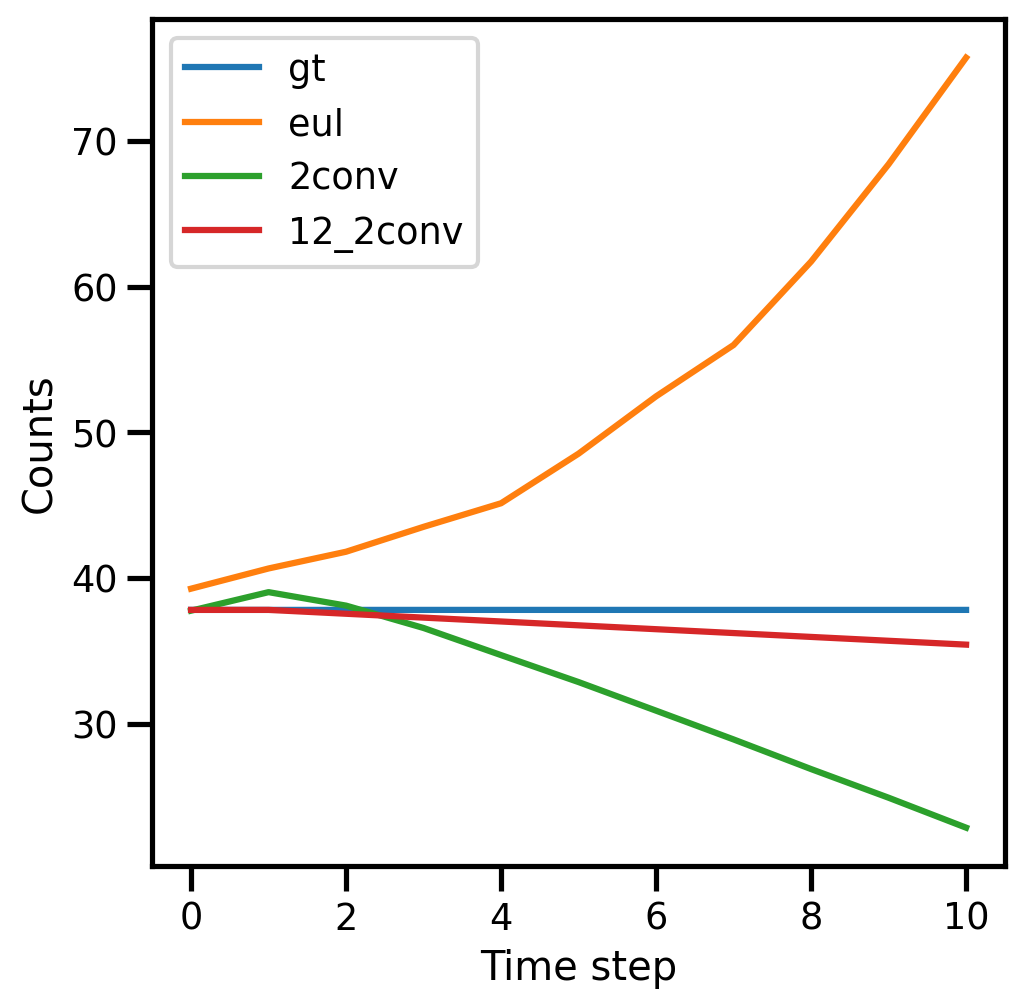

In [39]:
gt_=np.zeros(11)
eul_=np.zeros(11)
ml_=np.zeros(11)
ml12_=np.zeros(11)

for i in range(11):
    gt_[i]=gt[i].sum()
    eul_[i]=eul[i].sum()
    ml_[i]=ml[i].sum()
    ml12_[i]=ml12[i].sum()

plt.rcParams["figure.figsize"] = [5.50, 5.50]
plt.plot(gt_, label='gt')
plt.plot(eul_, label='eul')
plt.plot(ml_, label='2conv')
plt.plot(ml12_, label='12_2conv')
    #print(sim.name)
plt.ylabel('Counts')
plt.xlabel('Time step')
plt.legend()

plt.show()



- discuss a plan?
- ideas: learn to produce ensemble of lagrangian trajectories: 
   * way cheaper learn stochasticity 
   * less data to process
   * coordinate related
   * can cup with missing data, unstructured data..
- and then learn structuring instructured grids
   